# Portfolio Optimization

Using scipy's minimize function to optimize our portfolio 

In [65]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
import datetime as dt

In [67]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days = 5*365)

## Using BDO, EW, MBT, PNB, SECB, and UBP stocks as example

In [70]:
adj_close_df = pd.read_excel("PH Stocks.xlsx")
adj_close_df = adj_close_df.set_index("Date")
adj_close_df.head()

,BDO,EW,MBT,PNB,SECB,UBP
Date,,,,,,
2019-10-04,143.5,11.82,68.0,43.50,197.9,59.05
2019-10-07,140.0,11.70,68.0,44.00,197.0,59.10
2019-10-08,143.0,11.72,67.3,43.05,194.6,59.05
2019-10-09,143.4,11.62,66.0,42.95,191.0,59.00
2019-10-10,145.0,11.78,67.8,43.50,199.0,59.00


In [72]:
tickers = adj_close_df.columns
tickers = list(tickers)
tickers

['BDO', 'EW', 'MBT', 'PNB', 'SECB', 'UBP']

## Calculating log returns

In [74]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()
log_returns.head()

,BDO,EW,MBT,PNB,SECB,UBP
Date,,,,,,
2019-10-07,-0.024693,-0.010204,0.000000,0.011429,-0.004558,0.000846
2019-10-08,0.021202,0.001708,-0.010347,-0.021827,-0.012258,-0.000846
2019-10-09,0.002793,-0.008569,-0.019505,-0.002326,-0.018673,-0.000847
2019-10-10,0.011096,0.013675,0.026907,0.012724,0.041031,0.000000
2019-10-11,0.013699,0.021831,0.002946,-0.015055,-0.005038,0.000000


## Plotting the stock price performances of each company

<Axes: title={'center': 'Cummulative Returns over time'}, xlabel='Date'>

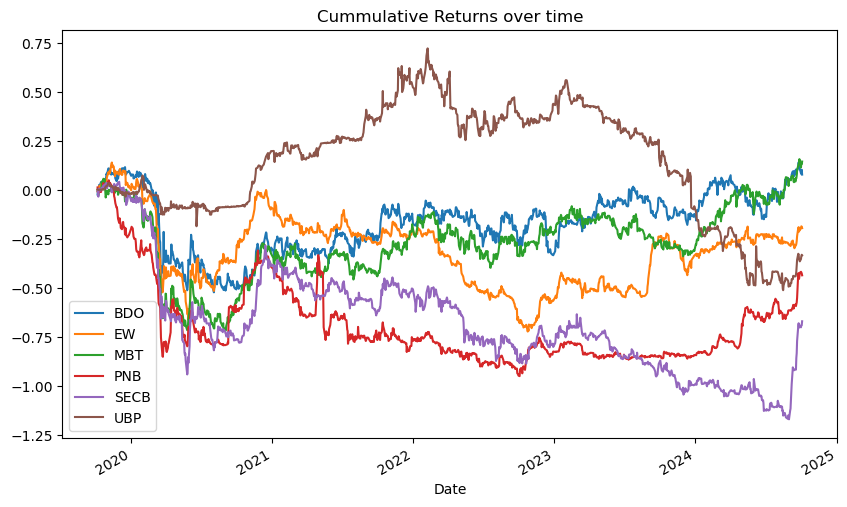

In [86]:
cummulative_returns = log_returns.cumsum()
cummulative_returns.plot(title = "Cummulative Returns over time", figsize = (10,6))

## Creating a covariance matrix of our stocks

In [76]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,BDO,EW,MBT,PNB,SECB,UBP
BDO,0.137341,0.037855,0.051202,0.031396,0.045545,0.013391
EW,0.037855,0.072604,0.032570,0.026008,0.036127,0.007094
MBT,0.051202,0.032570,0.104202,0.024401,0.039964,0.011296
PNB,0.031396,0.026008,0.024401,0.090090,0.025030,0.006593
SECB,0.045545,0.036127,0.039964,0.025030,0.104434,0.013962
UBP,0.013391,0.007094,0.011296,0.006593,0.013962,0.095389


## Setting up our functions (Standard Deviation, Expected Return, Sharpe Ratio)

In [99]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Setting up the variables, constraints, and bounds for Scipy's Minimize function

In [80]:
# .02 is widely used as the risk free rate. I dont have access to PSEI API for more accurate risk free rate
risk_free_rate = .02

# We are negating sharpe ratio for scipy's minimize function.
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Setting up our constraints and bounds
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.30) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.11027981637446534
       x: [ 3.000e-01  3.000e-01  3.000e-01  0.000e+00  0.000e+00
            1.000e-01]
     nit: 4
     jac: [-2.133e-01  8.542e-02 -2.486e-01  3.398e-01  5.240e-01
            2.608e-01]
    nfev: 28
    njev: 4

## Optimizing our portfolio using Scipy's Minimize function

In [82]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
BDO: 0.3000
EW: 0.3000
MBT: 0.3000
PNB: 0.0000
SECB: 0.0000
UBP: 0.1000
Expected Annual Return: -0.0054
Expected Volatility: 0.2303
Sharpe Ratio: -0.1103


## Plotting the results

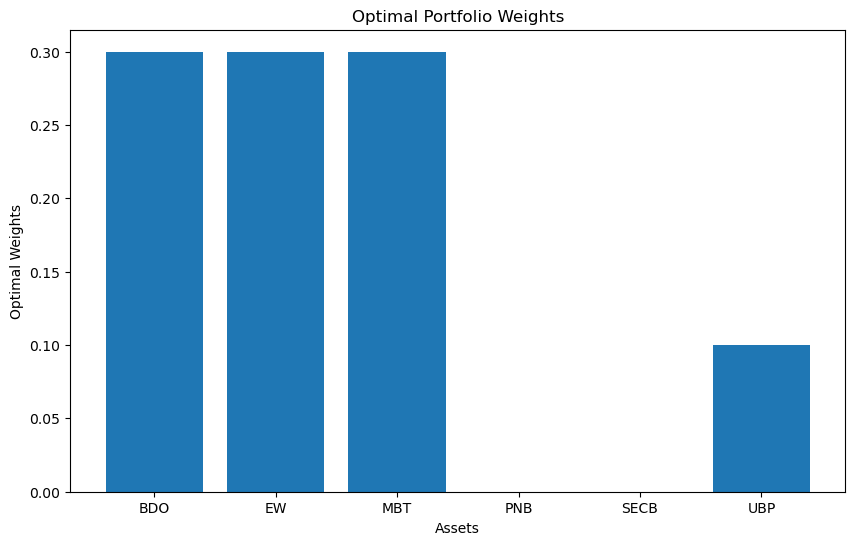

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

## Conclusion

Using Scipy's Minimize function, we managed to optimize our portfolio. The model chose to put 30% of our portfolio to BDO, EW, and MBT while 10% to UBP. To further observe this result, let's check the performance comparison of the 4 chosen companies compared to unchosen companies (PNB and SECB)

### Performance of the chosen companies

<Axes: title={'center': 'Cummulative Returns over time'}, xlabel='Date'>

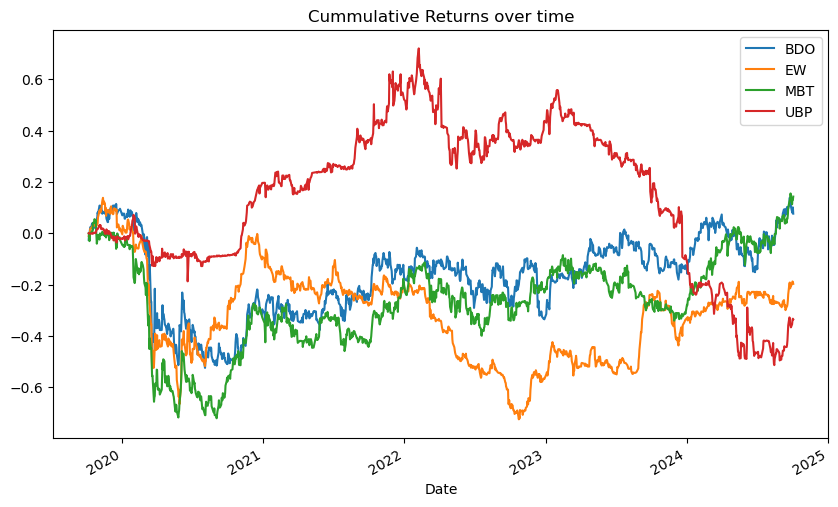

In [127]:
chosen = cummulative_returns.drop(columns=['PNB', 'SECB'])
chosen.plot(title = "Cummulative Returns over time", figsize = (10,6))

### Performance of the unchosen companies

<Axes: title={'center': 'Cummulative Returns over time'}, xlabel='Date'>

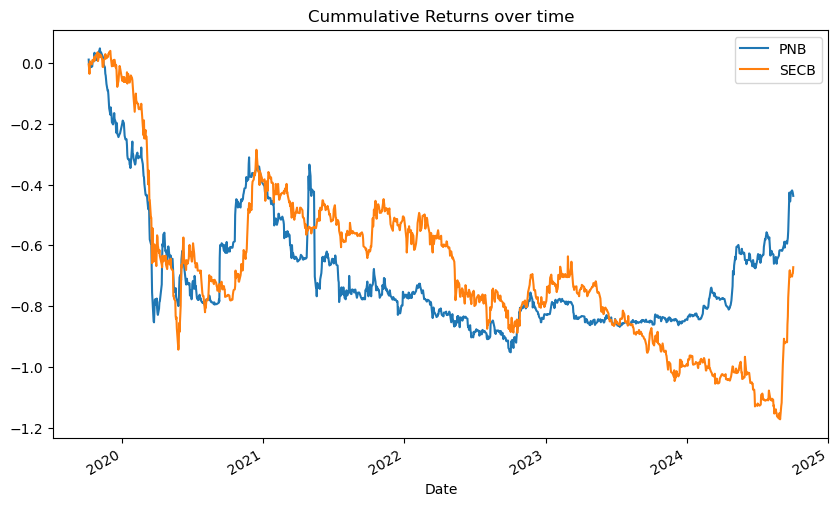

In [129]:
unchosen = cummulative_returns[['PNB', 'SECB']]
unchosen.plot(title = "Cummulative Returns over time", figsize = (10,6))